# Text Classification with 20 newsgroups dataset
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

See also: http://qwone.com/~jason/20Newsgroups/

For simplification purpose, we take only a sub-set of the groups.

## Step 2 Case
See https://octopeek.atlassian.net/wiki/spaces/INNOV/pages/1799192581/explainable+Text+Classification for details.

Tested with SHAP 0.37.0

In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories,
                                  shuffle=True, remove=('headers', 'footers', 'quotes'), random_state=0)

In [2]:
#Check target names
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [3]:
#Number of elements
len(twenty_train.data)

2257

In [17]:
#Display a sample of messages
n=3
for i in range(5):
    print('Message : ',twenty_train.data[i].split("\n"))
    print('From : ',twenty_train.target_names[twenty_train.target[i]])

Message :  ['', 'John, ', '', 'While I will not take the time to rebut you point by point, I will suggest', 'three current works which I think will be helpful in your quest to answer', 'this question.  John Dominic Crossan (Professor of Religion at De Paul Univ)-', '_The Cross That Spoke_ Harper and Row Pub. 1988, Also his latest work ', '_The Historical Jesus - The Life of A Mediterranean Jewish Peasant_ Harper', 'and Row Pub. 1991,  Also two works of Burton Mack (Professor of New Testament', 'at the Claremont Graduate School) _A Myth of Innocence_ Fortress Press 1988,', 'And his latest book _The Lost Gospel: The Book of Q and Christian Origins_', "Harper and Row, 1992.  You might start with Mack's book on Q and then ", 'examine the others afterward.  However I think that once you do that you will', 'see that your "evidence" is not as sturdy as you\'d like.  Most of the tired', 'arguements you stated, assume eyewitness accounts, such is not the case. But', 'Anyway look at Mack and Cro

In [4]:
#All in one: tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', lowercase=True,
                             norm='l2', use_idf=True)
X_train_tfidf = vectorizer.fit_transform(twenty_train.data)
X_train_tfidf.shape

(2257, 28865)

In [5]:
#sample of words used by vectorizer
import random
random.seed(0)
random.sample(vectorizer.get_feature_names(),20)

['victorious',
 'heaven',
 'strandard',
 'individually',
 '68',
 'dicto',
 'melinda',
 'locals',
 'hypothesised',
 'telescope',
 'unsuccessful',
 'ephraim',
 'lessons',
 'genus',
 'packet',
 'cornflakes',
 'mathematically',
 'blade',
 'duke',
 'blasphemous']

## Training a classifier

In [32]:
# Try SVM with elasticnet (i.e mix of l1 & l2 penalty)
from sklearn.linear_model import SGDClassifier
mloss = 'hinge'
clf = SGDClassifier(loss=mloss, penalty='elasticnet',
                    alpha=1e-4, random_state=0,
                    max_iter=50, tol=None)
clf.fit(X_train_tfidf, twenty_train.target)

SGDClassifier(max_iter=50, penalty='elasticnet', random_state=0, tol=None)

In [33]:
#display the model
clf

SGDClassifier(max_iter=50, penalty='elasticnet', random_state=0, tol=None)

In [34]:
print(f'Model score: {clf.score(X_train_tfidf, twenty_train.target)}')

Model score: 0.9827204253433761


## Test the model with sample messages

In [35]:
#Test with sample messages
docs_new = ['God is love', 'OpenGL on the GPU is fast',
            'God is love. Come to meet Jesus in the church']
#X_new_counts = count_vect.transform(docs_new)
#X_new_tfidf = tfidf_transformer.transform(X_new_counts)
X_new_tfidf = vectorizer.transform(docs_new)

predicted = clf.predict(X_new_tfidf)
#proba = clf.predict_proba(X_new_tfidf)
predicted

array([3, 1, 3], dtype=int64)

In [36]:
#detailed predictions
for i in range(len(docs_new)):
    #print(f'{docs_new[i]} => {predicted[i]} ({twenty_train.target_names[predicted[i]]}) with proba: {proba[i]}')
    print(f'{docs_new[i]} => {predicted[i]} ({twenty_train.target_names[predicted[i]]})')

God is love => 3 (soc.religion.christian)
OpenGL on the GPU is fast => 1 (comp.graphics)
God is love. Come to meet Jesus in the church => 3 (soc.religion.christian)


## Explanation with SHAP

In [37]:
import shap
shap.__version__

'0.37.0'

In [38]:
import shap
shap.initjs()
#explainer = shap.LinearExplainer(clf, X_train_tfidf)

#Now using base Explainer with automatic algo selection (for SVM)
#explainer = shap.Explainer(clf, X_train_tfidf, algorithm='auto')
explainer = shap.Explainer(clf, shap.sample(X_train_tfidf,100), algorithm='auto')

#For RandomForest
#explainer = shap.Explainer(clf, X_train_tfidf, algorithm='tree') #Not working bug
#explainer = shap.TreeExplainer(clf, data=X_train_tfidf[:,:100].toarray() )#crash
#explainer = shap.TreeExplainer(clf, feature_perturbation='tree_path_dependent' ) #crash also at shap_values computation
#explainer = shap.PermutationExplainer(clf, shap.sample(X_train_tfidf,10)) #Not working

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [39]:
type(explainer)

shap.explainers._linear.Linear

In [40]:
#Because we are using linear explainer, SHAP expected_value seems to be in the log-odds space 
# (see: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html)
for i in range(len(explainer.expected_value)):
    print(f"Expected value for class {i}: {explainer.expected_value[i]:.3}")

Expected value for class 0: -0.897
Expected value for class 1: -0.475
Expected value for class 2: -0.709
Expected value for class 3: -0.587


In [42]:
#Explanation for first example (identity scale)
i = 0
X_test_array = X_new_tfidf[i].toarray() #Convert sparse to dense array
#shap_values = explainer.shap_values(X_test_array, check_additivity=False)
shap_values = explainer.shap_values(X_test_array)
#len(shap_values)
max_display = 5
#For class 3 (i.e the predicted one)
c = 3
c = predicted[i]
print(f"Explanations for predicted class {c} ({twenty_train.target_names[c]}):")
explainer.expected_value[c]
shap_values[c].shape
#len(shap_values[c].shape)
#shap_values[c].flatten().shape
#len(shap_values[c].flatten().shape)
shap.force_plot(explainer.expected_value[c],shap_values[c], X_test_array,
                link="identity", feature_names=vectorizer.get_feature_names())

Explanations for predicted class 3 (soc.religion.christian):


In [43]:
#Explanation for first example (logit scale)
c = predicted[i]
print(f"Explanations for class {c} ({twenty_train.target_names[c]}): (with logit scale)")
explainer.expected_value[c]
shap_values[c].shape
#len(shap_values[c].shape)
#shap_values[c].flatten().shape
#len(shap_values[c].flatten().shape)
shap.force_plot(explainer.expected_value[c],shap_values[c], X_test_array,
                link="logit", feature_names=vectorizer.get_feature_names())

Explanations for class 3 (soc.religion.christian): (with logit scale)


In [44]:
#Second example elt (identity scale)
i = 1
X_test_array = X_new_tfidf[i].toarray() #Convert sparse to dense array
shap_values = explainer.shap_values(X_test_array)

c = predicted[i]
print(f"Explanations for class {c} ({twenty_train.target_names[c]}):")
shap.force_plot(explainer.expected_value[c],shap_values[c], X_test_array,
                feature_names=vectorizer.get_feature_names())

Explanations for class 1 (comp.graphics):


In [45]:
#Explanation (logit scale)
c = predicted[i]
print(f"Explanations for class {c} ({twenty_train.target_names[c]}): (with logit scale)")

shap.force_plot(explainer.expected_value[c],shap_values[c], X_test_array,
                link="logit", feature_names=vectorizer.get_feature_names())

Explanations for class 1 (comp.graphics): (with logit scale)


In [46]:
#Explanation for third example
i = 2
X_test_array = X_new_tfidf[i].toarray() #Convert sparse to dense array
shap_values = explainer.shap_values(X_test_array)

c = predicted[i]
print(f"Explanations for class {c} ({twenty_train.target_names[c]}):")
shap.force_plot(explainer.expected_value[c],shap_values[c], X_test_array,
                link="identity", feature_names=vectorizer.get_feature_names())

Explanations for class 3 (soc.religion.christian):


In [47]:
c = predicted[i]
print(f"Explanations for class {c} ({twenty_train.target_names[c]}): (with logit scale)")

shap.force_plot(explainer.expected_value[c],shap_values[c], X_test_array,
                link="logit", feature_names=vectorizer.get_feature_names())

Explanations for class 3 (soc.religion.christian): (with logit scale)


## Other UIs

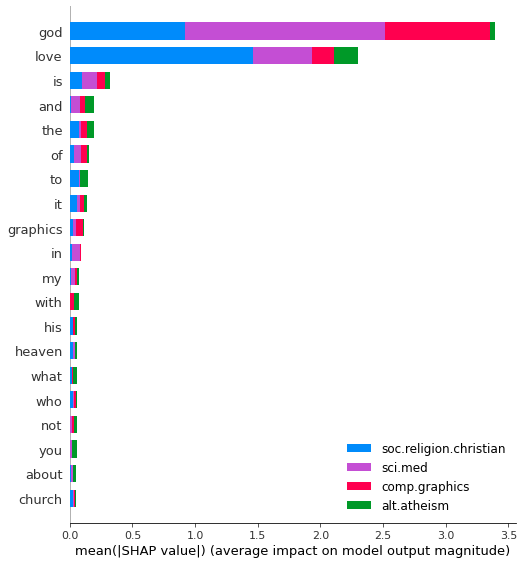

In [48]:
#Summary bar plot
# First sample , all classes explained
i = 0
X_test_array = X_new_tfidf[i].toarray() #Convert sparse to dense array
shap_values = explainer.shap_values(X_test_array)
shap.summary_plot(shap_values, X_test_array,
                  feature_names=vectorizer.get_feature_names(), class_names=twenty_train.target_names)

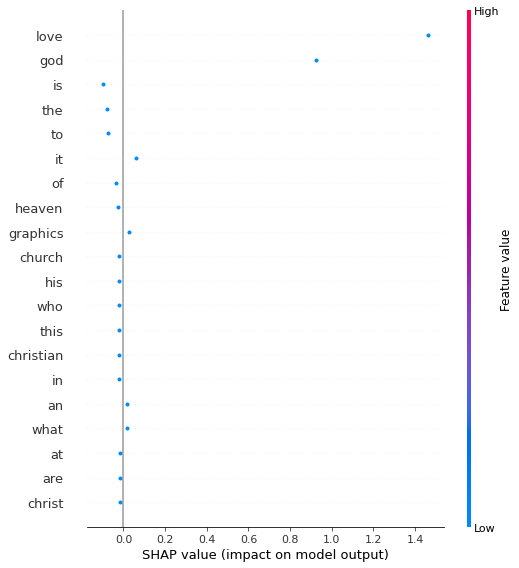

In [49]:
#summary plot for a single class
c = predicted[i]
shap.summary_plot(shap_values[c], X_test_array,
                  feature_names=vectorizer.get_feature_names(), class_names=twenty_train.target_names)

# Test with Random Forest model (pb)

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_tfidf, twenty_train.target)

RandomForestClassifier(random_state=0)

In [24]:
print(f'Model score: {clf.score(X_train_tfidf, twenty_train.target)}')

Model score: 0.9831634913602126


In [25]:
#For RandomForest, I tested multiple explainers without success
#explainer = shap.Explainer(clf, X_train_tfidf, algorithm='tree') #Not working bug
#explainer = shap.TreeExplainer(clf, data=X_train_tfidf[:,:100].toarray() )#crash
#explainer = shap.TreeExplainer(clf, feature_perturbation='tree_path_dependent' ) #crash also at shap_values computation
#explainer = shap.PermutationExplainer(clf, shap.sample(X_train_tfidf,10)) #Not working
explainer = shap.KernelExplainer(clf.predict_proba, shap.sample(X_train_tfidf,100)) #crash when computing shap_values

In [26]:
for i in range(len(explainer.expected_value)):
    print(f"Expected value for class {i}: {explainer.expected_value[i]:.3}")

Expected value for class 0: 0.184
Expected value for class 1: 0.31
Expected value for class 2: 0.225
Expected value for class 3: 0.281


In [27]:
#Explanation for first example (identity scale)
i = 0
X_test_array = X_new_tfidf[i].toarray() #Convert sparse to dense array
#shap_values = explainer.shap_values(X_test_array, check_additivity=False)
shap_values = explainer.shap_values(X_test_array)
#shap_values = explainer.shap_values(X_test_array)

TypeError: 'NoneType' object is not subscriptable